# Damped bead on a rotating hoop: SINDy

From Sec. 3.5 in Strogatz.  Full equation:
$$
m R \ddot{\phi} = -b \dot{\phi} - m g \sin \phi + m R \omega^2 \sin \phi \cos \phi
$$

If we introduce nondimensionalizations
$$
\gamma = \frac{R \omega^2}{g} \hspace{2cm} \epsilon = \frac{m^2 g R}{b^2}  \hspace{2cm} T = \frac{b}{mg},
$$
the equation becomes
$$
\epsilon \frac{d^2 \phi}{d \tau^2} = - \frac{d \phi}{d \tau} - \sin \phi + \gamma \sin \phi \cos \phi.
$$
For $\epsilon \ll 1$ and $\gamma = \mathcal{O}(1)$, the system is overdamped and approximately first-order.  The system undergoes a pitchfork bifurcation at $\gamma = 1$.

In [89]:
import numpy as np
import numpy.random as rng

from scipy.integrate import odeint


# Matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rc('font', family='serif')
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('axes', labelsize=20)
mpl.rc('axes', titlesize=20)
mpl.rc('figure', figsize=(6, 4))
%config InlineBackend.figure_format = 'retina'

from scipy import linalg

# Simulate dynamics

$$
m R \ddot{\phi} = -b \dot{\phi} - m g \sin \phi + m R^2 \omega \sin \phi \cos \phi
$$

In [90]:
# number of times experiment was performed 
nsamples = int(20)

m = np.random.uniform(1, 2, nsamples)
R = np.random.uniform(1e-1, 30, nsamples)
b = np.random.uniform(1, 10, nsamples)
g = 9.8 + 0*np.random.random(nsamples)
# w is omega
w = np.random.uniform(1e-2, 1, nsamples)

'''
vertically stacks the arrays to get the following format:
[[randomly generated m values], 
 [all the R values],
 [all the b values],
 [all the g values],
 [all the w values],]
'''
P = np.vstack([m, R, b, g, w])

# these are the dimensionless groups that I want to get from buckingham pi
eps = m**2 * g * R / b**2
gam = R * w**2 / g
T = b/(m*g)

In [91]:
# honestly confused how this works
# what is y??
def rhs(y, p):
    m, R, b, g, w = p
    return np.array([y[1],
                     (-b*y[1]-m*g*np.sin(y[0])+m*R*w**2*np.sin(y[0])*np.cos(y[0]))/(m*R)])

def run_sim(p, phi0, t):
    return odeint(lambda y, t: rhs(y, p), phi0, t)


In [92]:
'''
Took me a while to understand this but
phi0 is an array of the initial values for angle, i.e. phi, and the angular velocity, i.e. dphi
For initial conditions, we assume the pendulum is (nearly) vertical and (nearly) at rest.
'''
phi0 = 0.2*np.random.randn(nsamples, 2)

# 500 time values evenly spaced out from 0-10
t = np.linspace(0, 10, 500)  # Dimensional time
dt = t[1]-t[0]

# Initialises empty arrays
phi = np.zeros([nsamples, len(t)])
dphi = np.zeros([nsamples, len(t)])
ddphi = np.zeros([nsamples, len(t)])
for i in range(nsamples):
    y =  run_sim(P[:, i], phi0[i, :], t)
    phi[i, :] = y[:, 0]
    dphi[i, :] = y[:, 1]
    ddphi[i, :] = rhs(y.T, P[:, i])[1, :]

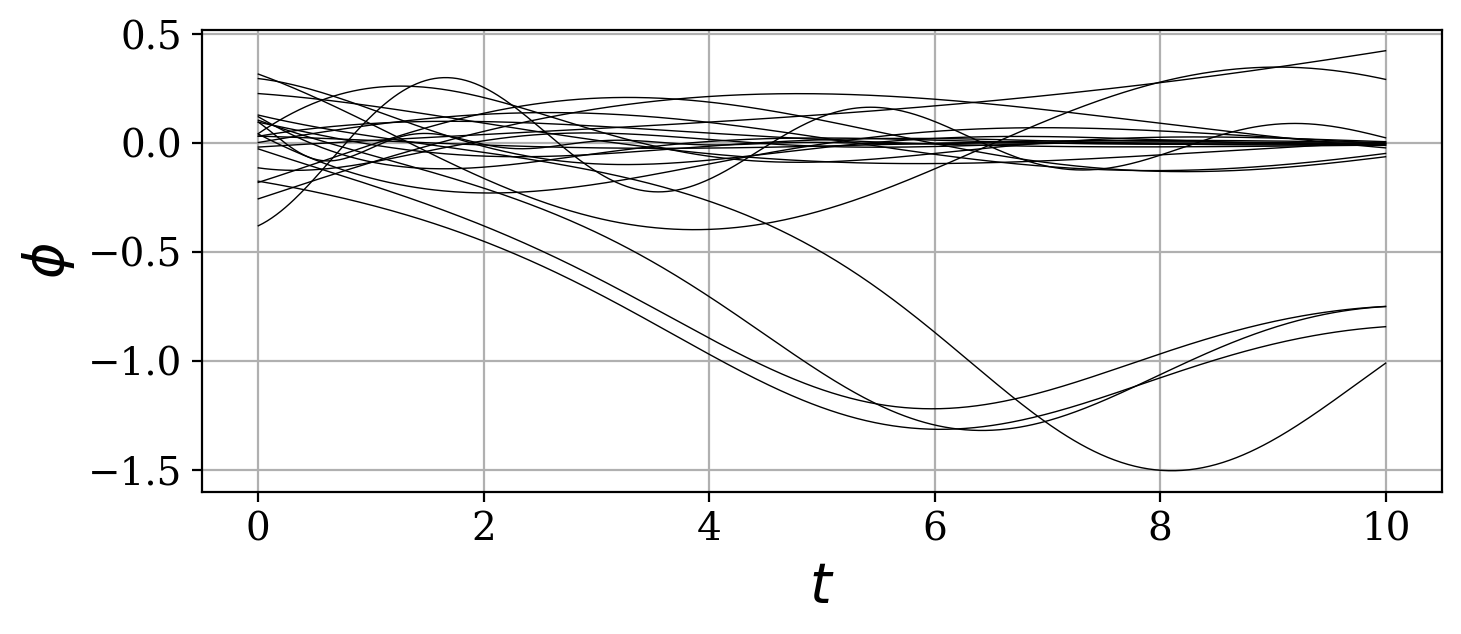

In [93]:
plt.figure(figsize=(8, 3))
plt.plot(t, phi.T, c='k', lw=0.5)
plt.xlabel(r'$t$')
plt.ylabel(r"$\phi$")
plt.grid()
plt.show()

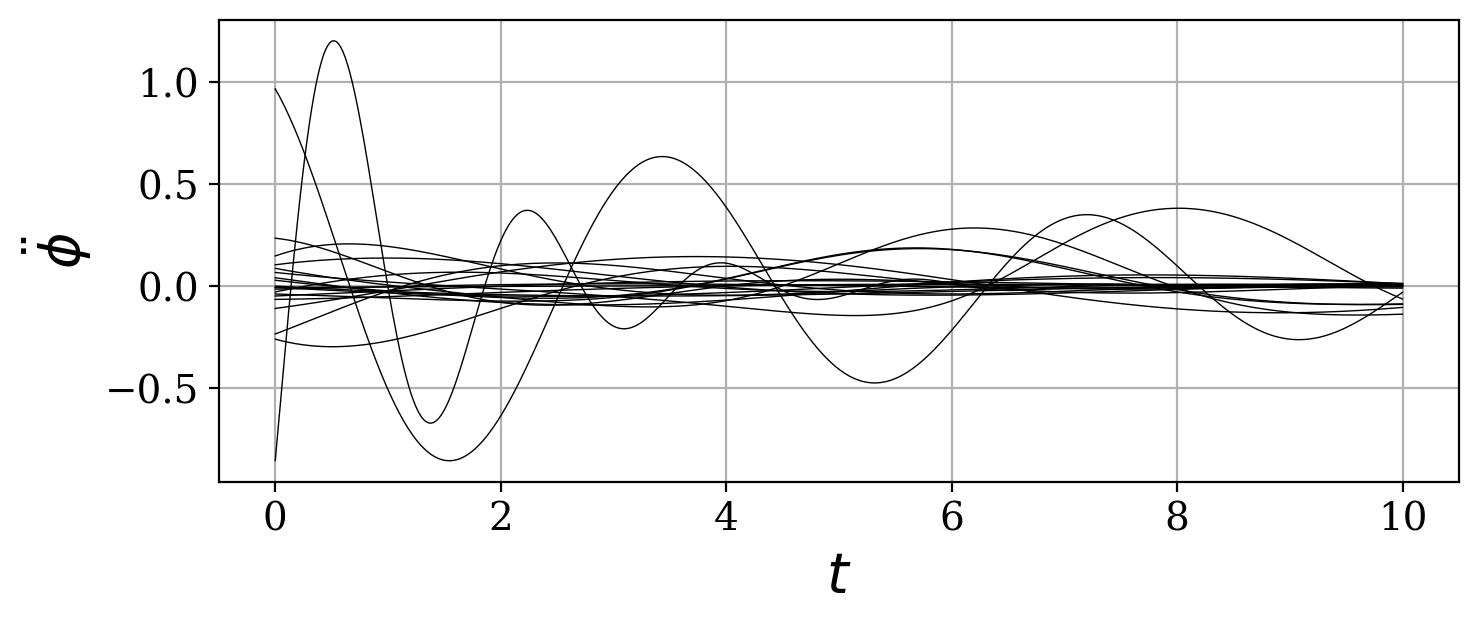

In [94]:
plt.figure(figsize=(8, 3))
plt.plot(t, ddphi.T, c='k', lw=0.5)
plt.xlabel(r'$t$')
plt.ylabel(r"$\ddot{\phi}$")
plt.grid()
plt.show()

# Nullspace search

In [95]:
from itertools import compress, product, combinations

from math import isnan, isinf

# this collinearity code is never even used??? 
# could just comment it out and it affects nothing
# # Very inefficient
# def is_collinear(v1, v2):
#     # Return True if v1 and v2 are collinear vectors
#     r = v1/v2
#     x = []
#     for i, ri in enumerate(r):
#         if np.isfinite(ri) and abs(ri) > 0:
#             x.append(ri)
#     if len(x)>0 and not np.any(np.array(x)-x[0]):
#         return True
#     else:
#         return False

def number_exists(num, nondim):
    # Return True if num (or a collinear to it) already exists in list 
    if not np.any(num):
        return True
    # Ignore collinearity here to avoid having to define more "p_fns"
    """for discovered in nondim:
        if is_collinear(num, discovered):
            return True"""
    return False


def get_nondim_numbers(dim_matrix, degree, num_params, time_vec=None):
    """
    Returns all possible dimensionless numbers in nullspace up to degree.
    
    If time_vec is included, should give the dimensions of time in dim_matrix rows
        e.g. [0, 0, 1]
        In this case, also returns all possible timescales
    """
    '''
    Makes an array where every sub-array is a possible combination for the powers
    of the parameters e.g.
    [[2, 2, 2, 2, 2],...,[0, 0, 1, 0, 0],...]
    '''
    all_combinations = np.array(list(product(*[range(-degree, degree+1)] * num_params)))
    idxsort = np.argsort(np.sum(np.abs(all_combinations), axis=1))
    all_combinations = all_combinations[idxsort]  
    nondim_list = []
    timescale_list = []
    for i in range(all_combinations.shape[0]):
        # takes one possible parameter power combo
        pi_candidate = all_combinations[i, :]
        
        # checks whether matrix multiplication of dim_matrix and this possible pi-group
        # results in a null vector i.e. the pi_candidate is part of the nullspace of the matrix
        if not np.any(dim_matrix @ pi_candidate):
            
            # this checks if the pi_candidate is a null vector i.e. [0, 0, 0, 0, 0]
            # if it is not, then it is added to the list
            if not number_exists(pi_candidate, nondim_list):
                nondim_list.append(pi_candidate)
                
        # checks if a time_vec was passed in as a parameter, and 
        # not sure why time_vec is being subtracted...
        elif (time_vec is not None) and (not np.any( dim_matrix @ pi_candidate - time_vec )):
            
            # same null vector check
            if not number_exists(pi_candidate, timescale_list):
                timescale_list.append(pi_candidate)
    return nondim_list, timescale_list


In [97]:
# Dimension matrix: [L, M, T] x [m, R, b, g, w]
D = np.array([[0, 1, 0], [1, 0, 0], [1, 1, -1], [1, 0, -2], [0, 0, -1]]).T

# Parameter matrix
P = np.vstack([ np.repeat(m, len(t)),
                np.repeat(R, len(t)),
                np.repeat(b, len(t)),
                np.repeat(g, len(t)),
                np.repeat(w, len(t)) ]).T

time_vec = np.array([0, 0, 1])

# print(D.shape)
nondim_list, timescale_list = get_nondim_numbers(D, 2, D.shape[1], time_vec=time_vec)

print(nondim_list)
print()
print(timescale_list)

[array([-1, -1,  1,  0, -1]), array([-1,  0,  1, -1,  1]), array([ 0,  1,  0, -1,  2]), array([ 0, -1,  0,  1, -2]), array([ 1,  0, -1,  1, -1]), array([ 1,  1, -1,  0,  1]), array([-2, -1,  2, -1,  0]), array([ 2,  1, -2,  1,  0]), array([ 2,  0, -2,  2, -2]), array([ 2,  2, -2,  0,  2]), array([-2, -2,  2,  0, -2]), array([-2,  0,  2, -2,  2])]

[array([ 0,  0,  0,  0, -1]), array([ 1,  1, -1,  0,  0]), array([-1,  0,  1, -1,  0]), array([ 0,  1,  0, -1,  1]), array([ 1,  0, -1,  1, -2]), array([-1, -1,  1,  0, -2]), array([ 1,  2, -1, -1,  2]), array([-1,  1,  1, -2,  2]), array([-2,  0,  2, -2,  1]), array([-2, -1,  2, -1, -1]), array([ 2,  2, -2,  0,  1]), array([ 2,  1, -2,  1, -1])]


In [98]:
P.shape

(10000, 5)

In [99]:
R.shape

(20,)

In [100]:
len(t)

500

# pySINDy optimizer and sympy

In [12]:
import sympy as sym

# Define candidate functions
q_fns = [lambda q: q[1],
         lambda q: q[0],
         lambda q: q[0]**2,
         lambda q: q[0]**3,
         lambda q: q[0]**4,
         lambda q: q[0]**5,
         lambda q: q[0]**6,
         lambda q: q[0]**7
        ]

p_fns = [lambda pi: 1+0*pi[0],
         lambda pi: pi[0],
         lambda pi: pi[1]]

In [13]:
def Theta(Q, Pi):
    return np.vstack(
    [
        [
            q_fns[m](Q)*p_fns[n](Pi) for m in range(len(q_fns))
        ]
        for n in range(len(p_fns))  # Loops over this first, so first M functions are g[0]
    ]).T

In [14]:
q_sym = sym.symbols('m, R, b, g, \omega')

In [15]:
phi.shape

(20, 500)

In [16]:
import pysindy as ps

def fit_all_dynamics(nondim_list, timescale_list, num_nondim, threshold, verbose=False):
    from IPython.display import display, Math
    
    input_combinations = list(combinations(nondim_list, num_nondim))
    loss_list = []
    param_list = []
    param_names = []
    for T_vec in timescale_list:
        print(T_vec)
        Pi_t = np.exp( np.log(P) @ T_vec ).T  # Timescale
        
        # Quantity of interest scaled by time
        q = np.vstack([phi.flatten(), Pi_t*dphi.flatten()])
        dq =  (Pi_t**2*ddphi.flatten())[:, None]

        for pi_vecs in input_combinations:
            
            # Compute dimensionless parameters
            Pi = np.exp( np.log(P) @ np.vstack(pi_vecs).T ).T
            
            # Fit SINDy model
            opt = ps.STLSQ(threshold=threshold, alpha=0.0, max_iter=5)
            lib = Theta(q, Pi)
            opt.fit(lib, dq)
            test_loss = linalg.norm(dq - lib @ opt.coef_.T)

            # Save results
            loss_list.append(test_loss)
            
            # Save this parameter combination
            test_params = [sym.prod(q_sym**T_vec)]
            test_params.append([sym.prod(q_sym**pi_vec) for pi_vec in pi_vecs])
            param_names.append(test_params)
            param_list.append( (T_vec, pi_vecs) )
            if verbose:
                display(Math(sym.latex(test_params)))
                print('test loss = ', test_loss)
                print('----------------------------')
    return param_list, param_names, loss_list

In [17]:
threshold = 1e-2
num_nondim=2
param_list, param_names, loss_list = fit_all_dynamics(nondim_list, timescale_list, num_nondim, threshold)

[ 0  0  0  0 -1]
[ 1  1 -1  0  0]
[-1  0  1 -1  0]


C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:219: ConvergenceWarning: STLSQ._reduce did not converge after 5 iterations.
  warnings.warn(


[ 0  1  0 -1  1]
[ 1  0 -1  1 -2]


C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.83178e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.72627e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.91596e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.66996e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:

[-1 -1  1  0 -2]


C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.03647e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.76676e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.2579e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=7.81332e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:1

[ 1  2 -1 -1  2]
[-1  1  1 -2  2]


C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:219: ConvergenceWarning: STLSQ._reduce did not converge after 5 iterations.
  warnings.warn(


[-2  0  2 -2  1]


C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:219: ConvergenceWarning: STLSQ._reduce did not converge after 5 iterations.
  warnings.warn(
C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:183: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:183: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:183: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:183: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\Mahnoor\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:183: UserWarning: Sparsity parameter is too big (0.01

[-2 -1  2 -1 -1]
[ 2  2 -2  0  1]


C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=4.82527e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.20576e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.00591e-16): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.61821e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:

[ 2  1 -2  1 -1]


C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.5637e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=3.5066e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=6.67901e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.81129e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Mahnoor\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:15

In [18]:
from IPython.display import display, Math
sort_idx = np.argsort(loss_list)

for i in range(5):
    display(Math(sym.latex(param_names[sort_idx[i]])))
    print('test loss = ', loss_list[sort_idx[i]])
    print('----------------------------')

<IPython.core.display.Math object>

test loss =  0.005487284590435272
----------------------------


<IPython.core.display.Math object>

test loss =  0.027957866321501674
----------------------------


<IPython.core.display.Math object>

test loss =  0.0758723205122599
----------------------------


<IPython.core.display.Math object>

test loss =  0.09472505098815293
----------------------------


<IPython.core.display.Math object>

test loss =  0.10689224005645709
----------------------------


Repeat for the best solution

In [19]:
model_idx = 0
T_vec = param_list[sort_idx[model_idx]][0]
pi_vec = param_list[sort_idx[model_idx]][1]

Pi_t = np.exp( np.log(P) @ T_vec ).T  # Timescale

# Quantity of interest scaled by time
q = np.vstack([phi.flatten(), Pi_t*dphi.flatten()])
dq =  (Pi_t**2*ddphi.flatten())[:, None]

# Compute dimensionless parameters
Pi = np.exp( np.log(P) @ np.vstack(pi_vec).T ).T

# Fit SINDy model
# Cubic terms
opt = ps.STLSQ(threshold=1e-1, alpha=0.00, max_iter=5)
lib = Theta(q, Pi)
opt.fit(lib, dq)
Xi3 = opt.coef_[0, :]

# Septic terms
opt = ps.STLSQ(threshold=5e-3, alpha=0.00, max_iter=5)
lib = Theta(q, Pi)
opt.fit(lib, dq)
Xi7 = opt.coef_[0, :]

In [20]:
lib = Theta(sym.symbols('q, \dot{q}'), sym.symbols('\pi_1, \pi_2')).flatten('F')
model = lib @ Xi3
model

-0.909082661591619*\dot{q}*\pi_1 - 0.19814534011055*\pi_1*q**3 - 0.876854733964267*\pi_1*q - 0.253972328084787*\pi_2*q**3 + 0.857780092193197*\pi_2*q

### Evaluate model for out-of-sample parameters

In [21]:
m = np.random.uniform(1, 2)
R = np.random.uniform(1e-1, 100)
b = np.random.uniform(1, 10)
g = 9.8
w = np.random.uniform(1e-2, 4)

# Difficult test case
m = 1.95
R = 34.8
b = 2.00
g = 9.8
w = 0.58
P_test = np.vstack([m, R, b, g, w])

In [22]:
# gamma, eps, T
R*w**2/g, m**2*g*R/b**2, b/m*g

(1.1945632653061222, 324.20115, 10.051282051282053)

In [30]:
model_idx = 0
T_vec, pi_vec = param_list[sort_idx[model_idx]]

Pi_t = np.exp( np.log(P_test).T @ T_vec )[0]  # Timescale
# Compute dimensionless parameters
Pi = np.exp( np.vstack(pi_vec) @ np.log(P_test) )

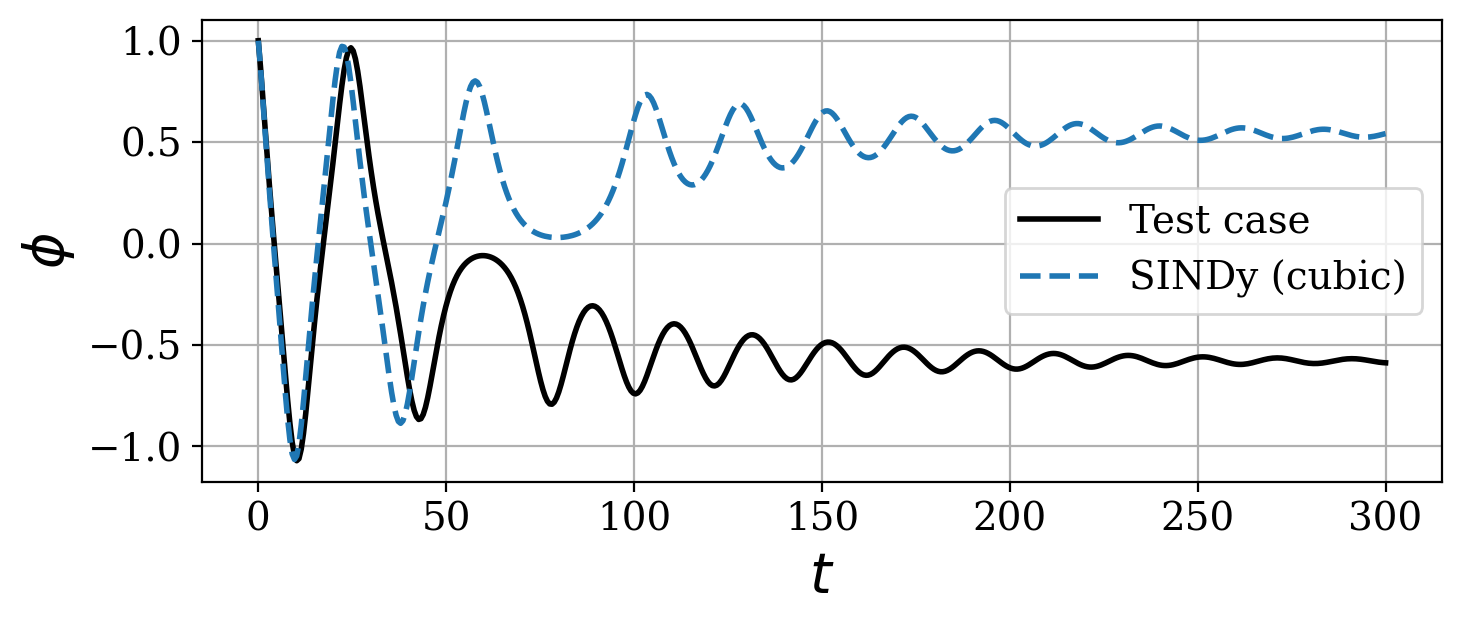

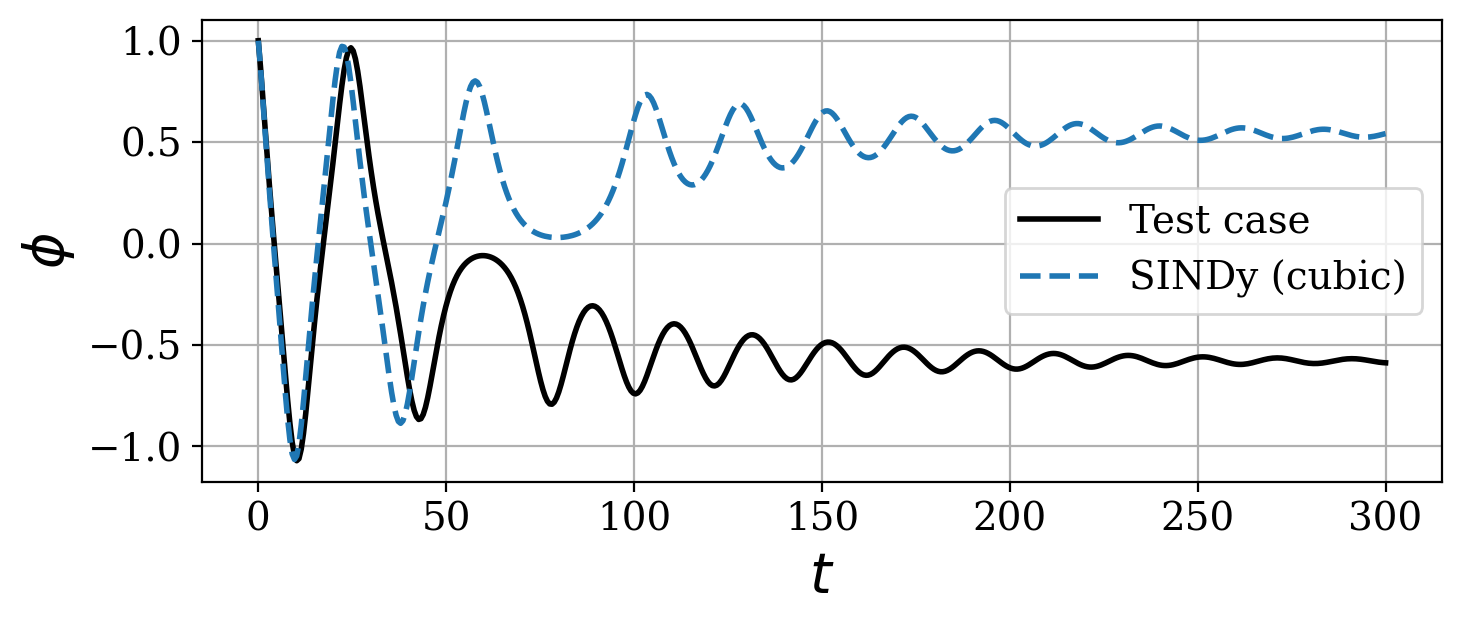

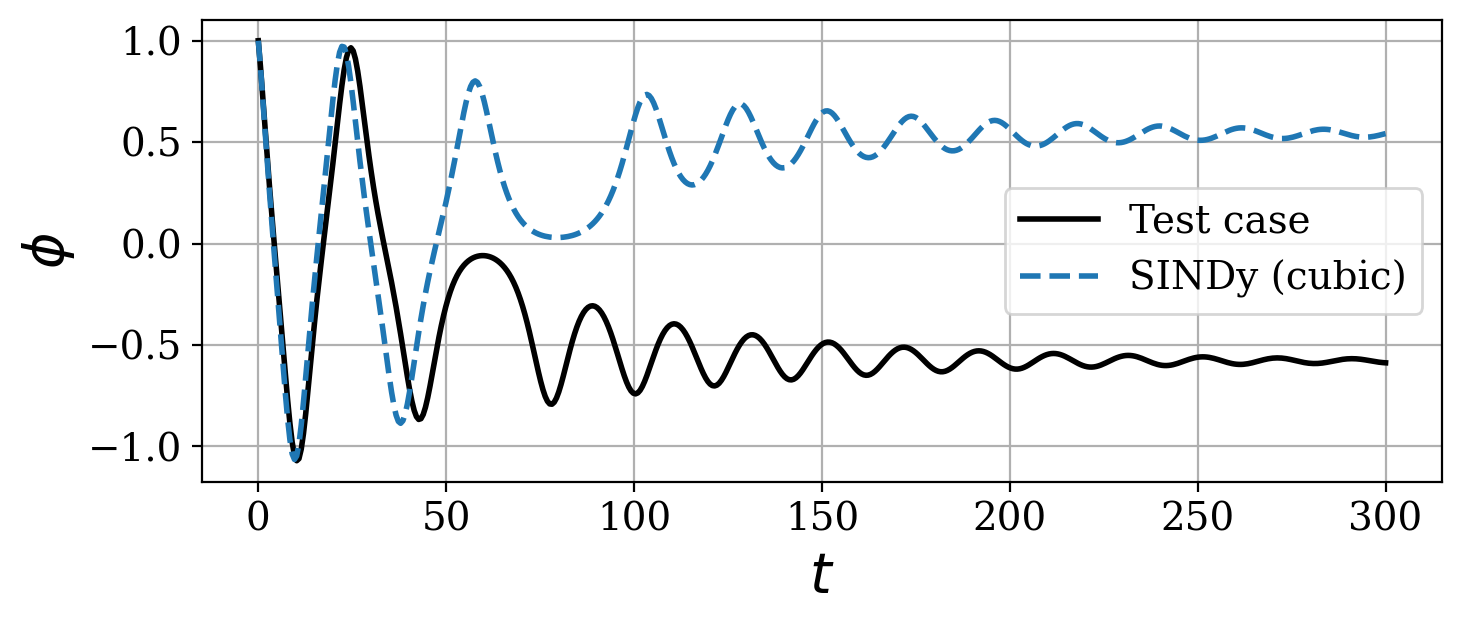

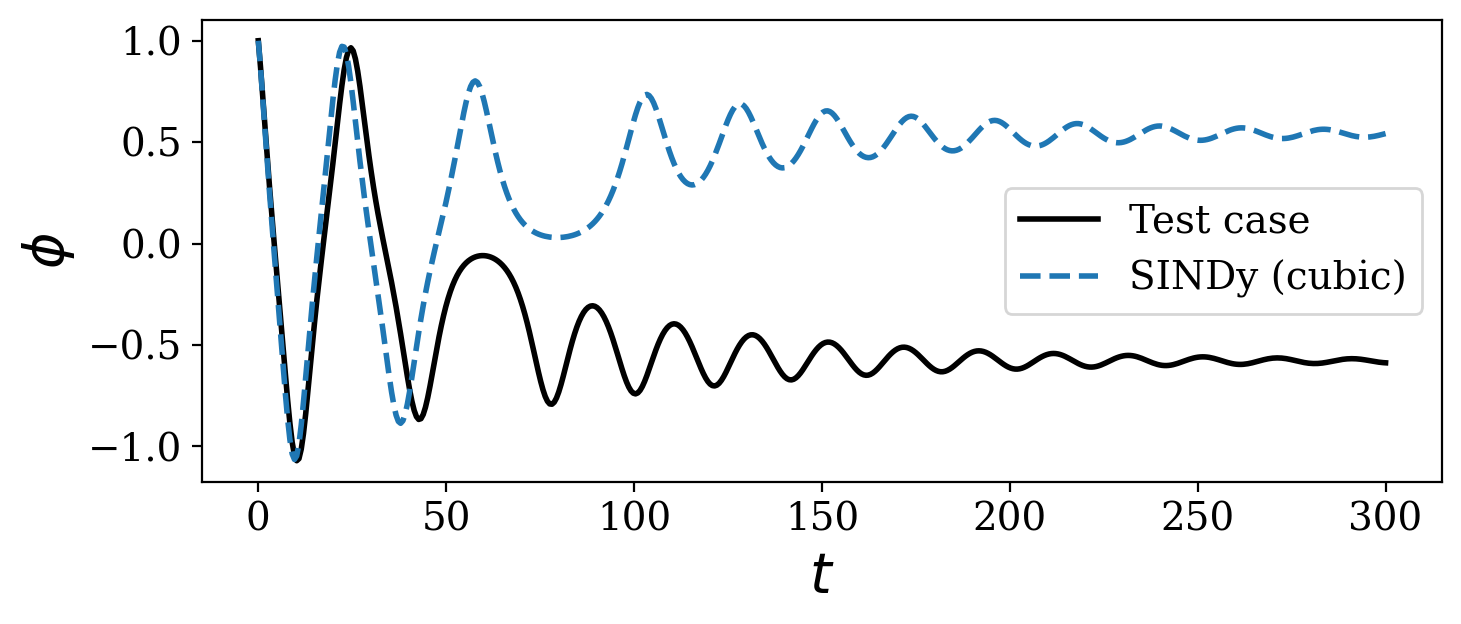

In [41]:
q_sym = sym.symbols('q, \dot{q}')
lib = Theta(q_sym, Pi).flatten('F')

t = np.linspace(0, 300, 500)  # Dimensional time
phi0_test = [1, -0.2]
phi0_nondim = phi0_test.copy()
phi0_nondim[1] *= Pi_t
phi_test = run_sim(P_test[:, 0], phi0_test, t)[:, 0]

rhs_sindy = sym.lambdify(q_sym, lib @ Xi3)
phi_sindy3 = odeint(lambda y, t: np.array([y[1], rhs_sindy(*y)]),
             phi0_nondim, t/Pi_t)[:, 0]

rhs_sindy = sym.lambdify(q_sym, lib @ Xi7)
phi_sindy7 = odeint(lambda y, t: np.array([y[1], rhs_sindy(*y)]),
             phi0_nondim, t/Pi_t)[:, 0]

plt.figure(figsize=(8, 3))
plt.plot(t, phi_test, c='k', lw=2, label='Test case')
plt.plot(t, phi_sindy3, lw=2, ls='--', label='SINDy (cubic)')
#plt.plot(t, phi_sindy7, lw=2, ls='--', label='SINDy (septic)')
plt.legend(fontsize=14)
plt.xlabel("$t$")
plt.ylabel(r"$\phi$")
plt.show()



# TODO:

* pySINDy compatibility for SR3
* Clean example notebook